In [ ]:
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from sklearn.model_selection import train_test_split

print(torch.cuda.is_available())

True


In [ ]:
import os
from pathlib import Path

target_dir = "dataset/label/grid_map"

for fname in os.listdir(target_dir):
    if not fname.endswith(".txt"):
        continue
    stem = Path(fname).stem  # grid_map_person_123
    parts = stem.split("_")
    idx = parts[-1]          # '123'
    if len(idx) == 3:        # 3자리인 경우만 처리
        new_idx = idx.zfill(4)  # → '0123'
        new_name = "_".join(parts[:-1] + [new_idx]) + ".txt"
        old_path = os.path.join(target_dir, fname)
        new_path = os.path.join(target_dir, new_name)
        print(f"Rename: {fname} -> {new_name}")
        os.rename(old_path, new_path)


Rename: grid_map_412.txt -> grid_map_0412.txt
Rename: grid_map_031.txt -> grid_map_0031.txt
Rename: grid_map_513.txt -> grid_map_0513.txt
Rename: grid_map_846.txt -> grid_map_0846.txt
Rename: grid_map_576.txt -> grid_map_0576.txt
Rename: grid_map_793.txt -> grid_map_0793.txt
Rename: grid_map_006.txt -> grid_map_0006.txt
Rename: grid_map_374.txt -> grid_map_0374.txt
Rename: grid_map_808.txt -> grid_map_0808.txt
Rename: grid_map_059.txt -> grid_map_0059.txt
Rename: grid_map_196.txt -> grid_map_0196.txt
Rename: grid_map_552.txt -> grid_map_0552.txt
Rename: grid_map_446.txt -> grid_map_0446.txt
Rename: grid_map_161.txt -> grid_map_0161.txt
Rename: grid_map_527.txt -> grid_map_0527.txt
Rename: grid_map_183.txt -> grid_map_0183.txt
Rename: grid_map_465.txt -> grid_map_0465.txt
Rename: grid_map_271.txt -> grid_map_0271.txt
Rename: grid_map_407.txt -> grid_map_0407.txt
Rename: grid_map_355.txt -> grid_map_0355.txt
Rename: grid_map_062.txt -> grid_map_0062.txt
Rename: grid_map_025.txt -> grid_m

In [ ]:
!python -m pip install --user -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 49.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [ ]:
import os, re
from pathlib import Path
from sklearn.model_selection import train_test_split

base_dir = "dataset"
image_dir = os.path.join(base_dir, "image")
obst_dir  = os.path.join(base_dir, "label", "grid_map")
goal_dir  = os.path.join(base_dir, "label", "grid_map_person")

KEEP_MISSING_GOAL = False   # goal 없으면 샘플 유지할지(False: 제거, True: None으로 둠)

# 숫자 인덱스 추출: 파일명(stem)에서 끝쪽 숫자 덩어리
_idx_pat = re.compile(r'(\d+)(?=\D*$)')
def get_index(path: str):
    m = _idx_pat.search(Path(path).stem)
    return m.group(1) if m else None

def list_files(d, exts):
    return [os.path.join(d, f) for f in os.listdir(d) if f.lower().endswith(exts)]

# 파일 수집
img_files  = list_files(image_dir, (".png", ".jpg", ".jpeg"))
obst_files = list_files(obst_dir,  (".txt",))
goal_files = list_files(goal_dir,  (".txt",))

# 인덱스 매핑
img_by_idx  = {get_index(p): p for p in img_files  if get_index(p) is not None}
obst_by_idx = {get_index(p): p for p in obst_files if get_index(p) is not None}
goal_by_idx = {get_index(p): p for p in goal_files if get_index(p) is not None}

# 공통 인덱스 계산 (goal 없는 샘플 처리 정책에 따라 달라짐)
if KEEP_MISSING_GOAL:
    common_idxs = sorted(set(img_by_idx) & set(obst_by_idx))  # goal 없어도 유지
else:
    common_idxs = sorted(set(img_by_idx) & set(obst_by_idx) & set(goal_by_idx))

# 최종 페어 구성
input_data = []
target_data = []  # (obst_path, goal_path or None)
missing_goal = 0
missing_obst = 0
missing_img  = 0

for idx in common_idxs:
    img  = img_by_idx.get(idx)
    obst = obst_by_idx.get(idx)
    goal = goal_by_idx.get(idx)

    if img is None:  missing_img += 1;  continue
    if obst is None: missing_obst += 1; continue

    if goal is None and not KEEP_MISSING_GOAL:
        # goal이 없고 유지하지 않기로 했으면 스킵
        continue

    input_data.append(img)
    target_data.append((obst, goal))  # goal이 없으면 None

# 리포트
print(f"총 이미지: {len(img_files)}, obst: {len(obst_files)}, goal: {len(goal_files)}")
print(f"매칭된 인덱스 수: {len(common_idxs)}")
if KEEP_MISSING_GOAL:
    print(f"goal 누락 허용 샘플 수: {sum(1 for _,g in target_data if g is None)}")
print(f"누락(스킵) img:{missing_img} obst:{missing_obst}")

# split
x_train, x_test, y_train, y_test = train_test_split(
    input_data, target_data, test_size=0.1, random_state=42, shuffle=True
)

print("Train size:", len(x_train))
print("Test size:", len(x_test))
print("예시:", x_train[0], y_train[0])


총 이미지: 5000, obst: 5000, goal: 5000
매칭된 인덱스 수: 5000
누락(스킵) img:0 obst:0
Train size: 4500
Test size: 500
예시: dataset/image/rgb_3716.png ('dataset/label/grid_map/grid_map_3716.txt', 'dataset/label/grid_map_person/grid_map_person_3716.txt')


In [ ]:
class GridMapDatasetSplit(Dataset):
    def __init__(self, input_list, target_list, size=(256,256), to_float=True):
        self.input_list = input_list          # 이미지 경로 리스트
        self.target_list = target_list        # (grid_map, grid_map_person) 경로 리스트
        self.size = size
        self.to_float = to_float

    def __len__(self):
        return len(self.input_list)

    @staticmethod
    def _read_txt_grid(path):
        return np.loadtxt(path, dtype=np.float32)

    def __getitem__(self, i):
        img_path = self.input_list[i]
        obst_path, goal_path = self.target_list[i]

        # 이미지 로드
        img = Image.open(img_path).convert("RGB")
        if self.size is not None:
            img = img.resize(self.size, Image.BILINEAR)
        img = np.asarray(img).astype("float32")
        if self.to_float:
            img /= 255.0
        img = torch.from_numpy(img).permute(2, 0, 1)  # (3,H,W)

        # 라벨 로드
        obst = self._read_txt_grid(obst_path)
        if os.path.exists(goal_path):
            goal = self._read_txt_grid(goal_path)
        else:
            goal = np.zeros_like(obst, dtype=np.float32)

        # resize
        if self.size is not None:
            obst_img = Image.fromarray((obst*255).astype(np.uint8))
            obst_img = obst_img.resize(self.size, Image.NEAREST)
            obst = (np.asarray(obst_img) > 127).astype(np.float32)

            goal_img = Image.fromarray((np.clip(goal,0,1)*255).astype(np.uint8))
            goal_img = goal_img.resize(self.size, Image.BILINEAR)
            goal = (np.asarray(goal_img).astype(np.float32) / 255.0)

        target = np.stack([obst, goal], axis=0).astype(np.float32)
        target = torch.from_numpy(target)

        return img, target


In [ ]:
# unet.py
import torch
import torch.nn as nn

def CBR(in_ch, out_ch):
    return nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding=1),
                         nn.BatchNorm2d(out_ch),
                         nn.ReLU(inplace=True))

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32):
        super().__init__()
        self.enc1 = nn.Sequential(CBR(in_ch, base), CBR(base, base))
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(CBR(base, base*2), CBR(base*2, base*2))
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = nn.Sequential(CBR(base*2, base*4), CBR(base*4, base*4))
        self.pool3 = nn.MaxPool2d(2)

        self.bott = nn.Sequential(CBR(base*4, base*8), CBR(base*8, base*8))

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, 2)
        self.dec3 = nn.Sequential(CBR(base*8, base*4), CBR(base*4, base*4))
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.dec2 = nn.Sequential(CBR(base*4, base*2), CBR(base*2, base*2))
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.dec1 = nn.Sequential(CBR(base*2, base), CBR(base, base))

        self.head = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b  = self.bott(self.pool3(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        logits = self.head(d1)  # (B,1,H,W)
        return logits


In [ ]:
# split 결과물: x_train, x_test, y_train, y_test
train_dataset = GridMapDatasetSplit(x_train, y_train)
val_dataset   = GridMapDatasetSplit(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
print("Train set size:", len(train_dataset))
print("Valid set size:", len(val_dataset))

# 샘플 확인
for i in range(4):
    img, target = train_dataset[i]
    print(f"[Train {i}]")
    print("  image:", x_train[i])
    print("  obst:", y_train[i][0])
    print("  goal:", y_train[i][1])
    print("  img shape:", img.shape, " target shape:", target.shape)

for i in range(1):
    img, target = val_dataset[i]
    print(f"[Valid {i}]")
    print("  image:", x_test[i])
    print("  obst:", y_test[i][0])
    print("  goal:", y_test[i][1])
    print("  img shape:", img.shape, " target shape:", target.shape)


Train set size: 4500
Valid set size: 500
[Train 0]
  image: dataset/image/rgb_3716.png
  obst: dataset/label/grid_map/grid_map_3716.txt
  goal: dataset/label/grid_map_person/grid_map_person_3716.txt
  img shape: torch.Size([3, 256, 256])  target shape: torch.Size([2, 256, 256])
[Train 1]
  image: dataset/image/rgb_3779.png
  obst: dataset/label/grid_map/grid_map_3779.txt
  goal: dataset/label/grid_map_person/grid_map_person_3779.txt
  img shape: torch.Size([3, 256, 256])  target shape: torch.Size([2, 256, 256])
[Train 2]
  image: dataset/image/rgb_0135.png
  obst: dataset/label/grid_map/grid_map_0135.txt
  goal: dataset/label/grid_map_person/grid_map_person_0135.txt
  img shape: torch.Size([3, 256, 256])  target shape: torch.Size([2, 256, 256])
[Train 3]
  image: dataset/image/rgb_4480.png
  obst: dataset/label/grid_map/grid_map_4480.txt
  goal: dataset/label/grid_map_person/grid_map_person_4480.txt
  img shape: torch.Size([3, 256, 256])  target shape: torch.Size([2, 256, 256])
[Valid 

In [ ]:
# dataset_single.py
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image

class GridMapDatasetSingle(Dataset):
    def __init__(self, input_list, target_list, size=(256,256), to_float=True, target_kind="obst"):
        """
        input_list: 이미지 경로 리스트
        target_list: (obst_path, goal_path) 튜플 리스트
        target_kind: "obst" 또는 "goal"
        """
        assert target_kind in ("obst", "goal")
        self.input_list = input_list
        self.target_list = target_list
        self.size = size
        self.to_float = to_float
        self.target_kind = target_kind

    def __len__(self):
        return len(self.input_list)

    @staticmethod
    def _read_txt_grid(path):
        return np.loadtxt(path, dtype=np.float32)

    def __getitem__(self, i):
        img_path = self.input_list[i]
        obst_path, goal_path = self.target_list[i]

        # --- 이미지 로드 ---
        img = Image.open(img_path).convert("RGB")
        if self.size is not None:
            img = img.resize(self.size, Image.BILINEAR)
        img = np.asarray(img).astype("float32")
        if self.to_float:
            img /= 255.0
        img = torch.from_numpy(img).permute(2, 0, 1)  # (3,H,W)

        # --- 타깃 1채널 선택 ---
        if self.target_kind == "obst":
            grid = self._read_txt_grid(obst_path)              # 기대: {0,1} or [0,1]
            # float 정밀도로 리사이즈 후 임계
            if self.size is not None:
                gimg = Image.fromarray(grid.astype(np.float32), mode="F")
                gimg = gimg.resize(self.size, Image.NEAREST)   # 라벨은 최근접
                grid = (np.asarray(gimg, dtype=np.float32) > 0.5).astype(np.float32)
        else:  # "goal"
            if os.path.exists(goal_path):
                grid = self._read_txt_grid(goal_path)          # 기대: [0,1] 연속값 허용
            else:
                grid = np.zeros_like(self._read_txt_grid(obst_path), dtype=np.float32)
            if self.size is not None:
                gimg = Image.fromarray(np.clip(grid, 0, 1).astype(np.float32), mode="F")
                gimg = gimg.resize(self.size, Image.NEAREST)  # 히트맵은 선형보간
                grid = np.asarray(gimg, dtype=np.float32)      # [0,1]

        target = torch.from_numpy(grid[None, ...].astype(np.float32))  # (1,H,W)
        return img, target


In [ ]:
# === 데이터로더(예시) ===
kind = "goal" #goal or obst
SIZE    = 256
BS      = 64
LR      = 1e-4 # default value : 1e-4
EPOCHS  = 100

train_ds = GridMapDatasetSingle(x_train, y_train, size=(SIZE,SIZE), target_kind=kind)  # 또는 "goal"
val_ds   = GridMapDatasetSingle(x_test, y_test, size=(SIZE,SIZE), target_kind=kind)

In [ ]:
# train_simple_single.py (핵심 변경만 표시)
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader
# from unet_single import UNet
# from dataset_single import GridMapDatasetSingle
# (경로 인덱싱/분할은 기존 그대로 사용)

if kind == "goal":
    OUT_DIR = "ckpt_single_goal"
elif kind == "obst":
    OUT_DIR = "ckpt_single_obst"



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)



train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BS, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:


# === 모델/로스/옵티마 ===
model = UNet(in_ch=3, out_ch=1, base=32).to(device)
#model.load_state_dict(torch.load("ckpt_single_goal/unet_ep100.pth"))
# t: 양성 픽셀 희소하면 1보다 크게 (예: 장애물: 5.0, goal 히트맵: 20.0 등)
pos_w_scalar = 5.0   # target_kind에 맞게 값 조정
pos_w = torch.tensor([pos_w_scalar], device=device, dtype=torch.float32)  # (1,)
crit = torch.nn.BCEWithLogitsLoss(pos_weight=pos_w)
opt  = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

best_val = float("inf")

@torch.no_grad()
def dice_from_logits(logits, targets, eps=1e-6):
    # logits/targets: (B,1,H,W)
    probs = torch.sigmoid(logits)
    num = 2 * (probs * targets).sum(dim=(0,2,3)) + eps
    den = (probs + targets).sum(dim=(0,2,3)) + eps
    return (num / den).item()   # 스칼라

for epoch in range(1, EPOCHS + 1):
    model.train()
    run_loss, n_tr = 0.0, 0
    for imgs, tgts in train_loader:
        imgs, tgts = imgs.to(device), tgts.to(device)
        logits = model(imgs)               # (B,1,H,W)
        loss = crit(logits, tgts)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        run_loss += loss.item() * imgs.size(0)
        n_tr     += imgs.size(0)

    tr_loss = run_loss / max(1, n_tr)

    # ---- validation ----
    model.eval()
    va_sum, n_va, dice_sum = 0.0, 0, 0.0
    with torch.no_grad():
        for imgs, tgts in val_loader:
            imgs, tgts = imgs.to(device), tgts.to(device)
            logits = model(imgs)
            vloss = crit(logits, tgts)
            va_sum  += vloss.item() * imgs.size(0)
            n_va    += imgs.size(0)
            dice_sum += dice_from_logits(logits, tgts)

    va_loss = va_sum / max(1, n_va)
    val_dice = dice_sum / max(1, len(val_loader))
    print(f"[{epoch:03d}/{EPOCHS}] train_loss={tr_loss:.4f}  val_loss={va_loss:.4f}  dice={val_dice:.4f}")
    print(kind)
    # 체크포인트
    torch.save(model.state_dict(), Path(OUT_DIR) / f"unet_ep{epoch:03d}.pth")
    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), Path(OUT_DIR)/"unet_best_val.pth")


[001/100] train_loss=0.7864  val_loss=0.6051  dice=0.5194
obst
[002/100] train_loss=0.5695  val_loss=0.5431  dice=0.5453
obst
[003/100] train_loss=0.5219  val_loss=0.4973  dice=0.5672
obst
[004/100] train_loss=0.4882  val_loss=0.4792  dice=0.5762
obst
[005/100] train_loss=0.4644  val_loss=0.4508  dice=0.5939
obst
[006/100] train_loss=0.4425  val_loss=0.4295  dice=0.6080
obst
[007/100] train_loss=0.4241  val_loss=0.4199  dice=0.6141
obst
[008/100] train_loss=0.4080  val_loss=0.4000  dice=0.6329
obst
[009/100] train_loss=0.3950  val_loss=0.3902  dice=0.6399
obst
[010/100] train_loss=0.3827  val_loss=0.3774  dice=0.6511
obst
[011/100] train_loss=0.3699  val_loss=0.3692  dice=0.6568
obst
[012/100] train_loss=0.3579  val_loss=0.3594  dice=0.6687
obst
[013/100] train_loss=0.3483  val_loss=0.3476  dice=0.6799
obst
[014/100] train_loss=0.3392  val_loss=0.3631  dice=0.6769
obst
[015/100] train_loss=0.3312  val_loss=0.3506  dice=0.6986
obst
[016/100] train_loss=0.3229  val_loss=0.3323  dice=0.69

In [ ]:
# 샘플 n개만 바로 확인
from torch.utils.data import DataLoader

n = 5
loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
for k, (img, tgt) in zip(range(n), loader):
    print(f"[{k}] img {tuple(img.shape)} dtype={img.dtype}  tgt {tuple(tgt.shape)} dtype={tgt.dtype}")
    # 기대: img=(1,3,H,W), tgt=(1,2,H,W)
    print("  tgt stats: min=%.3f max=%.3f mean=%.3f" % (tgt.min().item(), tgt.max().item(), tgt.mean().item()))


[0] img (1, 3, 256, 256) dtype=torch.float32  tgt (1, 2, 256, 256) dtype=torch.float32
  tgt stats: min=0.000 max=1.000 mean=0.095
[1] img (1, 3, 256, 256) dtype=torch.float32  tgt (1, 2, 256, 256) dtype=torch.float32
  tgt stats: min=0.000 max=1.000 mean=0.120
[2] img (1, 3, 256, 256) dtype=torch.float32  tgt (1, 2, 256, 256) dtype=torch.float32
  tgt stats: min=0.000 max=1.000 mean=0.112
[3] img (1, 3, 256, 256) dtype=torch.float32  tgt (1, 2, 256, 256) dtype=torch.float32
  tgt stats: min=0.000 max=1.000 mean=0.099
[4] img (1, 3, 256, 256) dtype=torch.float32  tgt (1, 2, 256, 256) dtype=torch.float32
  tgt stats: min=0.000 max=1.000 mean=0.112


In [ ]:
import os
import torch
import torch.nn.functional as F
from torchvision.utils import save_image, make_grid

# ----- 설정 -----
TARGET_KIND = kind    # "obst" 또는 "goal"
TH_OBST = 0.2           # 장애물 이진화 임계값
VIS_BATCHES = 2         # 저장할 배치 수
if kind == "obst":
    OUT_DIR = "infer_obst"
elif kind=="goal":
    OUT_DIR ="infer_goal"
os.makedirs(OUT_DIR, exist_ok=True)

# ----- 모델 로드 (단일 출력: out_ch=1) -----
model = UNet(in_ch=3, out_ch=1, base=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
weight = torch.load("obst_model_final2.pth", map_location=device)
model.load_state_dict(weight)
model.eval()

# 손실 함수 (외부에 loss_fn 없으면 BCEWithLogitsLoss 사용)
crit = globals().get("loss_fn", torch.nn.BCEWithLogitsLoss())

with torch.no_grad():
    for b, (imgs, tgts) in enumerate(val_loader):   # tgts: (B,1,H,W)
        if b >= VIS_BATCHES:
            break

        imgs = imgs.to(device)   # (B,3,H,W) [0,1]
        tgts = tgts.to(device)   # (B,1,H,W)

        logits = model(imgs)     # (B,1,h,w)
        probs  = torch.sigmoid(logits)  # (B,1,h,w)

        # ---- 타깃/예측 해상도 맞추기: 항상 NEAREST ----
        # goal 을 위한 수정 전
        if tgts.shape[-2:] != logits.shape[-2:]:
            tgts_rs = F.interpolate(tgts,  size=logits.shape[-2:], mode="nearest")
        else:
            tgts_rs = tgts

        # 손실
        vloss = crit(logits, tgts_rs).item()
        # # 손실 전 해상도 맞추기: logits -> tgts 크기로


        # ---- 시각화를 위해 원본 이미지 해상도로 업샘플(항상 NEAREST) ----
        H, W = imgs.shape[-2:]
        if probs.shape[-2:] != (H, W):
            pred_img = F.interpolate(probs, size=(H, W), mode="nearest")
            gt_img   = F.interpolate(tgts,  size=(H, W), mode="nearest")
        else:
            pred_img, gt_img = probs, tgts

        # ---- 오버레이 만들기 ----
        if TARGET_KIND == "obst":
            # 이진화 후 R 채널로 오버레이
            pred_bin = (pred_img > TH_OBST).float()                 # (B,1,H,W)
            overlay_pred = imgs.clone(); overlay_pred[:,0:1] = (overlay_pred[:,0:1] + pred_bin).clamp(0,1)
            overlay_gt   = imgs.clone(); overlay_gt[:,0:1] = (overlay_gt[:,0:1] + gt_img).clamp(0,1)

            tiles = [
                imgs.cpu(),
                overlay_gt.cpu(),
                overlay_pred.cpu(),
                pred_bin.repeat(1,3,1,1).cpu(),
                gt_img.repeat(1,3,1,1).cpu()
            ]
        else:
            # goal도 NEAREST: 보통 one-hot 유지. 필요시 threshold 추가 가능.
            overlay_pred = imgs.clone(); overlay_pred[:,1:2] = (overlay_pred[:,1:2] + pred_img).clamp(0,1)  # G
            overlay_gt   = imgs.clone(); overlay_gt[:,1:2]   = (overlay_gt[:,1:2]   + gt_img).clamp(0,1)    # G

            tiles = [
                imgs.cpu(),
                overlay_gt.cpu(),
                overlay_pred.cpu(),
                pred_img.repeat(1,3,1,1).cpu(),
                gt_img.repeat(1,3,1,1).cpu()
            ]

        grid = make_grid(torch.cat(tiles, dim=0), nrow=imgs.size(0))
        save_path = os.path.join(OUT_DIR, f"{TARGET_KIND}_valid_batch{b:03d}_loss{vloss:.4f}.png")
        save_image(grid, save_path)
        print(f"saved: {save_path}")


saved: infer_obst/obst_valid_batch000_loss0.1756.png
saved: infer_obst/obst_valid_batch001_loss0.1757.png


# ONNX convert

In [ ]:
import torch

ckpt = torch.load("goal_model_final.pth", map_location="cpu")
model = UNet()
model.load_state_dict(ckpt)
model.eval()

dummy = torch.randn(1, 3, 256, 256)   # 입력 크기 맞추기
torch.onnx.export(
    model, dummy, "goal_model_final.onnx",
    input_names=["input"], output_names=["logits"],  # logits(or probs) 네이밍
    opset_version=13,
    do_constant_folding=True,
    dynamic_axes=None  # 동적 원하면 {"input":{0:"N"}, "logits":{0:"N"}}
)

In [ ]:
import torch

ckpt = torch.load("goal_model_2.pth", map_location="cpu")
model = UNet()
model.load_state_dict(ckpt)
model.eval()

dummy = torch.randn(1, 3, 256, 256)   # 입력 크기 맞추기
torch.onnx.export(
    model, dummy, "goal_model.onnx",
    input_names=["input"], output_names=["logits"],  # logits(or probs) 네이밍
    opset_version=13,
    do_constant_folding=True,
    dynamic_axes=None  # 동적 원하면 {"input":{0:"N"}, "logits":{0:"N"}}
)

/tmp/ipykernel_956/233346602.py:9: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [ ]:
import onnx
m = onnx.load("obst_model.onnx")
onnx.checker.check_model(m)

In [ ]:
import onnx
m = onnx.load("goal_model.onnx")
onnx.checker.check_model(m)

# Calculate Model's Accuracy

In [ ]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def bin_confusion(pred_bin: torch.Tensor, tgt_bin: torch.Tensor):
    """
    pred_bin, tgt_bin: bool tensor [..., H, W]
    return: TP, FP, FN, TN (long)
    """
    tp = (pred_bin & tgt_bin).sum().long()
    fp = (pred_bin & ~tgt_bin).sum().long()
    fn = (~pred_bin & tgt_bin).sum().long()
    tn = (~pred_bin & ~tgt_bin).sum().long()
    return tp, fp, fn, tn

def metrics_from_conf(tp, fp, fn, tn, eps=1e-7):
    tp, fp, fn, tn = map(lambda x: x.float(), (tp, fp, fn, tn))
    p = tp + fn
    n = tn + fp
    acc  = (tp + tn) / (p + n + eps)
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    f1   = 2*tp / (2*tp + fp + fn + eps)
    iou  = tp / (tp + fp + fn + eps)
    dice = 2*tp / (2*tp + fp + fn + eps)
    spec = tn / (tn + fp + eps)
    bacc = 0.5*(rec + spec)
    return {
        "acc": acc.item(),
        "precision": prec.item(),
        "recall": rec.item(),
        "f1": f1.item(),
        "iou": iou.item(),
        "dice": dice.item(),
        "specificity": spec.item(),
        "balanced_acc": bacc.item(),
        "pos_ratio_gt": (p / (p+n+eps)).item()
    }

def _ensure_same_hw(pred, tgt):
    # pred: (B, C, H1, W1), tgt: (B, C or 1, H2, W2)
    if pred.shape[-2:] != tgt.shape[-2:]:
        tgt = F.interpolate(tgt.float(), size=pred.shape[-2:], mode="nearest")
    return pred, tgt

def _to_probs(pred):
    # pred: (B, C, H, W)
    if pred.dtype.is_floating_point:
        # 로짓이면 시그모이드, 이미 [0,1]이면 그대로
        if pred.min() < 0 and pred.max() > 1:
            return pred.sigmoid()
        return pred.clamp(0,1)
    return pred.float()

def _maybe_expand_tgt_channels(tgt, C):
    # tgt가 (B,1,H,W)인데 C>1인 경우, 채널수 맞추기(같은 마스크를 채널에 복제하지 않음)
    # 일반적으로 tgt는 C와 동일한 채널로 준비되어 있어야 함.
    if tgt.dim()==4 and tgt.size(1)==1 and C>1:
        # 채널이 다르면 여기서 에러로 알려주자 (침묵 복제는 위험)
        raise ValueError(f"Target has 1 channel but prediction has {C}. 맞는 라벨 텐서를 사용하세요.")
    return tgt

def dilate(tensor_bin: torch.Tensor, r: int):
    """tensor_bin: bool/0-1 (B,C,H,W), 사각 커널로 r픽셀 팽창"""
    if r <= 0: return tensor_bin
    k = 2*r + 1
    # max_pool로 팽창 효과
    out = F.max_pool2d(tensor_bin.float(), kernel_size=k, stride=1, padding=r)
    return (out > 0.5)

@torch.no_grad()
def evaluate_segmentation(model, val_loader, device="cuda", threshold=0.5, tolerance_rs=(0, 2, 4)):
    """
    model: 입력 -> (B, C, H, W) 로짓/확률 출력
    val_loader: (imgs, tgts) 배치 반환. tgts는 (B, C, H, W) 또는 (B,1,H,W) 이진(0/1)
    tolerance_rs: 관용 IoU 계산을 위한 팽창 반경 리스트(픽셀)
    return: {channel_name(or idx): metrics dict...}
    """
    model.eval()
    agg = {}  # per-channel accumulators of TP/FP/FN/TN
    agg_tol = {r:{} for r in tolerance_rs if r>0}

    for imgs, tgts in val_loader:
        imgs, tgts = imgs.to(device), tgts.to(device)
        with torch.cuda.amp.autocast(enabled=imgs.dtype==torch.float16):
            pred = model(imgs)

        pred, tgts = _ensure_same_hw(pred, tgts)
        probs = _to_probs(pred)
        B, C, H, W = probs.shape
        tgts = _maybe_expand_tgt_channels(tgts, C)

        # GT를 bool로
        if tgts.size(1) == 1 and C == 1:
            tgt_bin = (tgts > 0.5)
        else:
            tgt_bin = (tgts > 0.5)

        # 채널 루프 (채널명이 없으면 idx로)
        for c in range(C):
            p = probs[:, c]
            t = tgt_bin[:, c] if tgt_bin.size(1) == C else tgt_bin[:, 0]

            pred_bin = (p >= threshold)

            tp, fp, fn, tn = bin_confusion(pred_bin, t)
            agg.setdefault(c, {"tp":0,"fp":0,"fn":0,"tn":0})
            agg[c]["tp"] += tp
            agg[c]["fp"] += fp
            agg[c]["fn"] += fn
            agg[c]["tn"] += tn

            # 관용 IoU (양방향 팽창 IoU, 흔한 정의 중 하나)
            for r in tolerance_rs:
                if r <= 0: continue
                # GT 팽창과 Pred 팽창 둘 다 사용하여 근접 허용
                pred_d = dilate(pred_bin, r)
                tgt_d  = dilate(t, r)
                # tolerant TP/FP/FN
                tp_t = (pred_bin & tgt_d).sum().long()
                fp_t = (pred_bin & ~tgt_d).sum().long()
                fn_t = (~pred_bin & t).sum().long()
                # IoU_tolerant = tp / (tp+fp+fn)
                agg_tol[r].setdefault(c, {"tp":0,"fp":0,"fn":0})
                agg_tol[r][c]["tp"] += tp_t
                agg_tol[r][c]["fp"] += fp_t
                agg_tol[r][c]["fn"] += fn_t

    # 요약
    out = {}
    channel_names = getattr(val_loader.dataset, "channel_names", None)  # 있으면 사용
    for c, d in agg.items():
        name = channel_names[c] if channel_names and c < len(channel_names) else f"ch{c}"
        out[name] = metrics_from_conf(d["tp"], d["fp"], d["fn"], d["tn"])

    # 관용 IoU 추가
    for r, per_c in agg_tol.items():
        for c, d in per_c.items():
            name = channel_names[c] if channel_names and c < len(channel_names) else f"ch{c}"
            iou_t = (d["tp"].float() / (d["tp"] + d["fp"] + d["fn"] + 1e-7)).item()
            out[name][f"tolerant_iou@{r}px"] = iou_t

    # 마이크로 평균(전 채널 합산)
    if len(agg) > 1:
        tp = sum(d["tp"] for d in agg.values())
        fp = sum(d["fp"] for d in agg.values())
        fn = sum(d["fn"] for d in agg.values())
        tn = sum(d["tn"] for d in agg.values())
        out["micro_avg"] = metrics_from_conf(tp, fp, fn, tn)
        for r, per_c in agg_tol.items():
            tp_r = sum(d["tp"] for d in per_c.values())
            fp_r = sum(d["fp"] for d in per_c.values())
            fn_r = sum(d["fn"] for d in per_c.values())
            out["micro_avg"][f"tolerant_iou@{r}px"] = (tp_r.float() / (tp_r+fp_r+fn_r+1e-7)).item()
    return out


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_goal = UNet()
model_obst = UNet()
model_goal = model_goal.to(device)
model_obst = model_obst.to(device)
weight_goal = torch.load('goal_model_final.pth')
weight_obst = torch.load('obst_model_final.pth')

model_goal.load_state_dict(weight_goal)
model_obst.load_state_dict(weight_obst)
# (선택) 데이터셋에 채널명 명시해두면 결과에 이름으로 들어감
# val_dataset.channel_names = ["obst", "person"]

metrics = evaluate_segmentation(
    model_goal, val_loader,
    device=device,
    threshold=0.5,
    tolerance_rs=(0, 2, 4)  # 0은 일반 IoU, 2/4는 관용 IoU
)

# 출력

for ch, vals in metrics.items():
    print("===============")
    print(f" 모델 종류 : {kind}")
    print(f"\n=== {ch} ===")
    for k, v in sorted(vals.items()):
        print(f"{k:20s}: {v:.4f}")



/tmp/ipykernel_29/2269463762.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=imgs.dtype==torch.float16):


 모델 종류 : goal

=== ch0 ===
acc                 : 0.9553
balanced_acc        : 0.8220
dice                : 0.2155
f1                  : 0.2155
iou                 : 0.1208
pos_ratio_gt        : 0.0089
precision           : 0.1279
recall              : 0.6862
specificity         : 0.9577
tolerant_iou@2px    : 0.1540
tolerant_iou@4px    : 0.1912


In [ ]:
print(kind)

goal


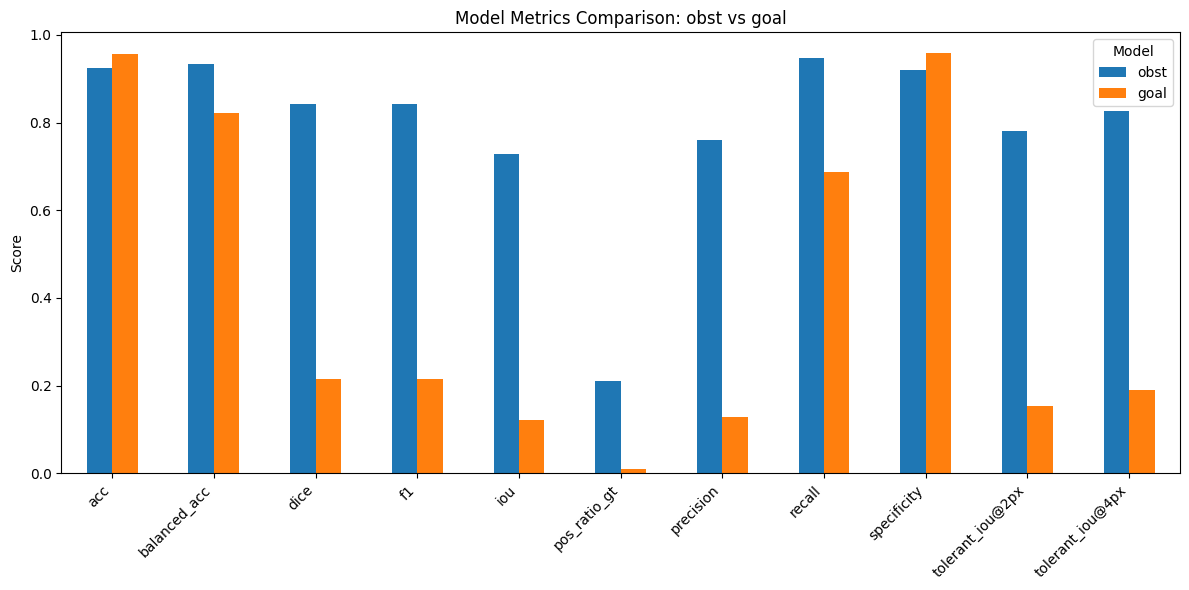

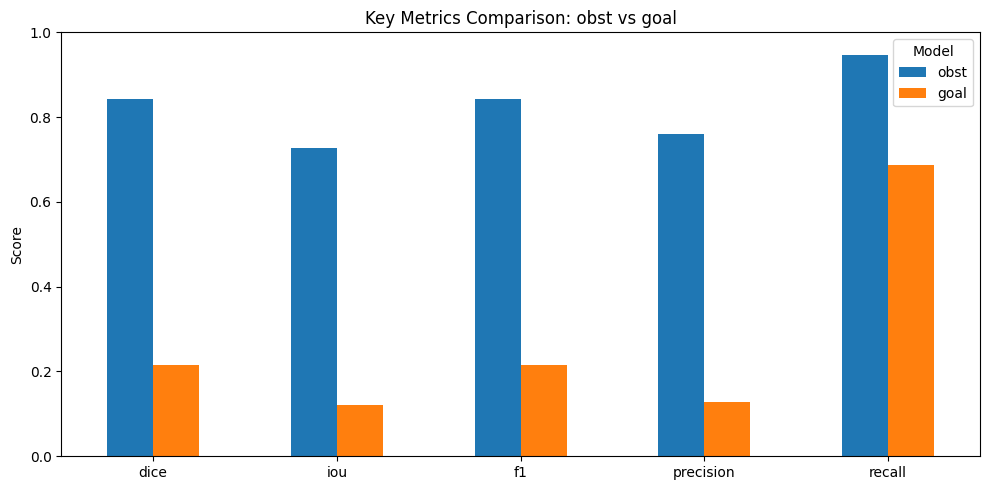

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ==== 데이터 정의 ====
metrics = {
    "acc":              [0.9253, 0.9553],
    "balanced_acc":     [0.9329, 0.8220],
    "dice":             [0.8424, 0.2155],
    "f1":               [0.8424, 0.2155],
    "iou":              [0.7277, 0.1208],
    "pos_ratio_gt":     [0.2110, 0.0089],
    "precision":        [0.7592, 0.1279],
    "recall":           [0.9460, 0.6862],
    "specificity":      [0.9198, 0.9577],
    "tolerant_iou@2px": [0.7800, 0.1540],
    "tolerant_iou@4px": [0.8257, 0.1912],
}

# DataFrame 생성 (행=metric, 열=model)
df = pd.DataFrame(metrics, index=["obst", "goal"]).T

# ==== 전체 지표 막대 그래프 ====
ax = df.plot(kind="bar", figsize=(12,6))
plt.title("Model Metrics Comparison: obst vs goal")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# ==== 주요 지표만 따로 ====
focus_metrics = ["dice", "iou", "f1", "precision", "recall"]
df_focus = df.loc[focus_metrics]

ax = df_focus.plot(kind="bar", figsize=(10,5))
plt.title("Key Metrics Comparison: obst vs goal")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()
